##### Copyright 2023 fbernaly.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Custom Model for ML Kit: Image classification

This notebook is based on the [Image classification notebook](https://www.tensorflow.org/tutorials/images/classification) found in [TensorFlow](https://www.tensorflow.org/).

The main focus of this notebook is to demonstrate how to convert a keras model to a [TensorFlow Lite](https://www.tensorflow.org/lite/) model, and how to make it compatible for on-device machine learning on mobile using [ML Kit](https://developers.google.com/ml-kit).

This tutorial shows how to create a [custom model](https://developers.google.com/ml-kit/custom-models) for [ML Kit](https://developers.google.com/ml-kit) to classify images of flowers using a `tf.keras.Sequential` model and load data using `tf.keras.utils.image_dataset_from_directory`. It demonstrates the following concepts:


* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process



## Setup

Import TensorFlow and other necessary libraries:

In [ ]:
import os
import matplotlib.pyplot as plt
import flatbuffers
import tensorflow as tf
import logging
import pathlib

## Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [ ]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

print("directory: {}".format(data_dir))

directory: /root/.keras/datasets/flower_photos


After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


## Load data using a Keras utility

Next, load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](https://www.tensorflow.org/tutorials/load_data/images) tutorial.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


Save those class names to `labels.txt`, it will be used later for metadata.

In [ ]:
label_file_path = 'labels.txt'
with open(label_file_path, 'w') as f:
    f.write('\n'.join(class_names))

## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [ ]:
import numpy as np

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


Or, you can include the layer inside your model definition, which can simplify deployment.The second approach is used here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

## Train Keras model

### Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit) in the training process. In this tutorial, you'll use [data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) and add dropout to your model.

[Overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit) generally occurs when there are a small number of training examples. [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You can implement data augmentation using the  [Keras image preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers#image_preprocessing) and [image data augmentation](https://www.tensorflow.org/guide/keras/preprocessing_layers#image_data_augmentation). These can be included inside your model like other layers, and run on the GPU.

Another technique to reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit) is to introduce [dropout regularization](https://developers.google.com/machine-learning/glossary#dropout_regularization) to the network.

When you apply [dropout to a layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout), it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer. To read more about it go [here](https://towardsdatascience.com/understanding-and-implementing-dropout-in-tensorflow-and-keras-a8a3a02c1bfa).

**NOTE**: This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [ ]:
num_classes = len(class_names)

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip(input_shape=(img_height,
                                                img_width,
                                                3)),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
    ]
)

model = tf.keras.Sequential([
  data_augmentation,

  tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  tf.keras.layers.Normalization(),

  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

### Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 normalization_1 (Normalizat  (None, 180, 180, 3)      7         
 ion)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)       

### Train the model

Train the model for 15 epochs with the Keras `Model.fit` method:

In [ ]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 11s 45ms/step - loss: 1.4640 - accuracy: 0.3764 - val_loss: 1.1918 - val_accuracy: 0.4809
Epoch 2/15
92/92 [==============================] - 3s 31ms/step - loss: 1.0931 - accuracy: 0.5572 - val_loss: 1.0299 - val_accuracy: 0.5804
Epoch 3/15
92/92 [==============================] - 3s 30ms/step - loss: 1.0064 - accuracy: 0.5943 - val_loss: 0.9718 - val_accuracy: 0.6063
Epoch 4/15
92/92 [==============================] - 3s 32ms/step - loss: 0.9567 - accuracy: 0.6264 - val_loss: 0.9394 - val_accuracy: 0.6253
Epoch 5/15
92/92 [==============================] - 3s 29ms/step - loss: 0.8992 - accuracy: 0.6465 - val_loss: 0.9436 - val_accuracy: 0.6322
Epoch 6/15
92/92 [==============================] - 3s 30ms/step - loss: 0.8634 - accuracy: 0.6635 - val_loss: 0.9114 - val_accuracy: 0.6567
Epoch 7/15
92/92 [==============================] - 3s 35ms/step - loss: 0.8318 - accuracy: 0.6802 - val_loss: 0.8818 - val_accuracy: 0.6717
Epoch 8/15
9

## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

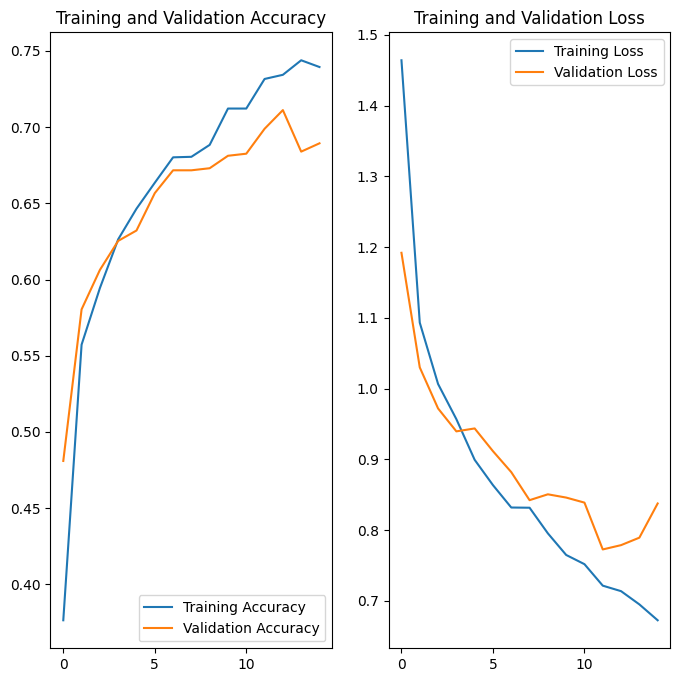

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data using Keras model

Use the trained Keras model to classify an image that wasn't included in the training or validation sets.

**Note**

```
# This is formatted as code
```

: Data augmentation and dropout layers are inactive at inference time.

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 89ms/step
This image most likely belongs to sunflowers with a 95.24 percent confidence.


## TensorFlow Lite

[TensorFlow Lite](https://www.tensorflow.org/lite/) is a set of tools that enables on-device machine learning by helping developers run their models on mobile, embedded, and edge devices.

### Convert the Keras Sequential model to a TensorFlow Lite model

To use the trained model with on-device applications, first [convert it](https://www.tensorflow.org/lite/models/convert) to a smaller and more efficient model format called a [TensorFlow Lite](https://www.tensorflow.org/lite/) model.

Take the trained Keras Sequential model and use `tf.lite.TFLiteConverter.from_keras_model` to generate a [TensorFlow Lite](https://www.tensorflow.org/lite/) model.

To use the [TensorFlow Lite](https://www.tensorflow.org/lite/) model in [ML Kit](https://developers.google.com/ml-kit) it should meet [these requirements](https://developers.google.com/ml-kit/custom-models#model-compatibility). For this example the data is FLOAT32 type, which should set before calling `converter.convert()`.

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# quantization, set the optimization mode and data type
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float32]

tflite_model = converter.convert()

# Save the model.
model_file = 'model.tflite'
with open(model_file, 'wb') as f:
  f.write(tflite_model)

The [TensorFlow Lite](https://www.tensorflow.org/lite/) model you saved in the previous step can contain several function signatures. The Keras model converter API uses the default signature automatically. Learn more about [TensorFlow Lite signatures](https://www.tensorflow.org/lite/guide/signatures).

### Add Metadata

To make the [TensorFlow Lite](https://www.tensorflow.org/lite/) model compatible with [ML Kit](https://developers.google.com/ml-kit), if the input tensor type is FLOAT32, it must specify the NormalizationOptions by [attaching Metadata](https://www.tensorflow.org/lite/models/convert/metadata) to the model.

There are three parts to the model metadata:

1. Model information - Overall description of the model as well as items such as license terms.
2. Input information - Description of the inputs and pre-processing required such as normalization.
3. Output information - Description of the output and post-processing required such as mapping to labels.

#### Model information

Metadata starts by creating a new model info:

In [ ]:
pip install tflite-support

In [ ]:
from tflite_support import metadata_schema_py_generated as _metadata_fb
from tflite_support import metadata as _metadata

In [ ]:
# Creates model info.
model_meta = _metadata_fb.ModelMetadataT()
model_meta.name = "YOUR_image_classifier_name"
model_meta.description = ("Identify the most prominent object in the "
                          "image from a set of %d categories." %
                          num_classes)
model_meta.version = "v1"
model_meta.author = "YOUR_name"
model_meta.license = ("Apache License. Version 2.0 "
                      "http://www.apache.org/licenses/LICENSE-2.0.")

#### Input / output information

This section shows you how to describe your model's input and output signature. This metadata may be used by automatic code generators to create pre- and post- processing code. To create input or output information about a tensor:

In [ ]:
# Creates input info.
input_meta = _metadata_fb.TensorMetadataT()

# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()

##### Image input

Image is a common input type for machine learning. TensorFlow Lite metadata supports information such as colorspace and pre-processing information such as normalization. The dimension of the image does not require manual specification since it is already provided by the shape of the input tensor and can be automatically inferred.

In [ ]:
input_meta.name = "image"
input_meta.description = (
    "Input image to be classified. The expected image is {0} x {1}, with "
    "three channels (red, blue, and green) per pixel. Each value in the "
    "tensor is a single byte between 0 and 255.".format(img_width, img_height))
input_meta.content = _metadata_fb.ContentT()
input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
input_meta.content.contentProperties.colorSpace = (
    _metadata_fb.ColorSpaceType.RGB)
input_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.ImageProperties)
input_normalization = _metadata_fb.ProcessUnitT()
input_normalization.optionsType = (
    _metadata_fb.ProcessUnitOptions.NormalizationOptions)
input_normalization.options = _metadata_fb.NormalizationOptionsT()
input_normalization.options.mean = [0]
input_normalization.options.std = [1]
input_meta.processUnits = [input_normalization]
input_stats = _metadata_fb.StatsT()
input_stats.max = [255]
input_stats.min = [0]
input_meta.stats = input_stats

##### Label output

Label can be mapped to an output tensor via an associated file using `TENSOR_AXIS_LABELS`.

In [ ]:
# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()
output_meta.name = "probability"
output_meta.description = "Probabilities of the {} labels respectively.".format(num_classes)
output_meta.content = _metadata_fb.ContentT()
output_meta.content.content_properties = _metadata_fb.FeaturePropertiesT()
output_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.FeatureProperties)
output_stats = _metadata_fb.StatsT()
output_stats.max = [1.0]
output_stats.min = [0.0]
output_meta.stats = output_stats
label_file = _metadata_fb.AssociatedFileT()
label_file.name = os.path.basename(label_file_path)
label_file.description = "Labels for objects that the model can recognize."
label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
output_meta.associatedFiles = [label_file]

##### Create the metadata Flatbuffers

Combine the model information with the input and output information:

In [ ]:
# Creates subgraph info.
subgraph = _metadata_fb.SubGraphMetadataT()
subgraph.inputTensorMetadata = [input_meta]
subgraph.outputTensorMetadata = [output_meta]
model_meta.subgraphMetadata = [subgraph]

b = flatbuffers.Builder(0)
b.Finish(
    model_meta.Pack(b),
    _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
metadata_buf = b.Output()

##### Pack metadata and associated files into the model
Once the metadata Flatbuffers is created, the metadata and the label file are written into the TFLite file via the populate method:

In [108]:
# copies model_file to export_path
export_model_path = "model_with_metadata.tflite"
tf.io.gfile.copy(model_file, export_model_path, overwrite=True)

# populates metadata
populator = _metadata.MetadataPopulator.with_model_file(model_file)
populator.load_metadata_buffer(metadata_buf)
populator.load_associated_files([export_model_path])
populator.populate()

ValueError: ignored

## Predict on new data using TensorFlow Lite model


You can access the TensorFlow Lite saved model signatures in Python via the `tf.lite.Interpreter` class.

Load the model with the `Interpreter`:

In [ ]:
model_path = export_model_path # model_file or export_model_path
interpreter = tf.lite.Interpreter(model_path=model_path)

Get the input and output details:

In [109]:
# Obtain input and output details of the model.
print("n--------Input Details of Model-------------------n")
input_details = interpreter.get_input_details()
print(input_details)

print("\nn--------Output Details of Model-------------------n")
output_details = interpreter.get_output_details()
print(output_details)

n--------Input Details of Model-------------------n
[{'name': 'serving_default_sequential_3_input:0', 'index': 0, 'shape': array([  1, 180, 180,   3], dtype=int32), 'shape_signature': array([ -1, 180, 180,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]

n--------Output Details of Model-------------------n
[{'name': 'StatefulPartitionedCall:0', 'index': 24, 'shape': array([1, 5], dtype=int32), 'shape_signature': array([-1,  5], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


Now allocate tensors so that we can use the `set_tensor()` method to feed the processed image

In [110]:
interpreter.allocate_tensors()

You have already tensorized that image and saved it as `img_array`. Now, pass it to `set_tensor()`.

In [111]:
interpreter.set_tensor(input_details[0]['index'], img_array)

Inference is performed by calling:

In [112]:
interpreter.invoke()

 Compute softmax activations, and then print the prediction for the class with the highest computed probability.

In [113]:
predictions = interpreter.get_tensor(output_details[0]['index'])
score_lite = tf.nn.softmax(predictions)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to sunflowers with a 95.24 percent confidence.


To read more about using the interpreter go [here](https://helloworld.co.in/article/image-classification-tensorflow-lite).

## Next steps

This tutorial showed how to train a model for image classification, test it, convert it to the [TensorFlow Lite](https://www.tensorflow.org/lite/) format and make it compatible for [ML Kit](https://developers.google.com/ml-kit) for on-device applications (such as an [image classification](https://developers.google.com/ml-kit/vision/image-labeling) and [object detection](https://developers.google.com/ml-kit/vision/object-detection)), and perform inference with the [TensorFlow Lite](https://www.tensorflow.org/lite/) model with the Python API.

You can download the generated tflite file (model_with_metadata.tflite) from the `Files` tab and use it in [Google's ML Kit sample app](https://github.com/googlesamples/mlkit) or in [google_ml_kit_flutter](https://github.com/flutter-ml/google_ml_kit_flutter) [example app](https://github.com/flutter-ml/google_ml_kit_flutter/tree/master/packages/example). Follow this [guide](https://developers.google.com/ml-kit/custom-models).

To get a copy of this [Python script](https://github.com/flutter-ml/mlkit-custom-model) and run it in your terminal go [here](https://github.com/flutter-ml/mlkit-custom-model).

You can learn more about TensorFlow Lite through [tutorials](https://www.tensorflow.org/lite/tutorials) and [guides](https://www.tensorflow.org/lite/guide).